In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage.color import rgb2gray
from skimage.io import imread, imshow
from scipy import ndimage
# from PIL import Image,ImageChops
# from colours import color_analysis1
import math 
import os
import glob 
import random

In [3]:
df=pd.read_csv('/Users/varsha/Desktop/Capstone project/resp.csv')
print(df.head())
list(df.columns)
df.shape

   ID  Tinea captisis  Alopecia areata  Melanoma  Healthy scalp     Img
0   1               1                0         0              0  1.jpeg
1   2               1                0         0              0  2.jpeg
2   3               1                0         0              0  3.jpeg
3   4               1                0         0              0  4.jpeg
4   5               1                0         0              0  5.jpeg


(47, 6)

In [4]:
import os
import glob 
img_dir = "/Users/varsha/Desktop/Capstone project/images_1" 
# Enter Directory of all images  
data_path = os.path.join(img_dir,'*g') 
files = glob.glob(data_path) 
data = [] 

In [5]:
for i in range(1,48):
    for f1 in files:
        tmp=f1.split("/")
        n=tmp[-1].split(".")    
        if(i==int(n[0])):
            img = cv2.imread(f1) 
            img=cv2.resize(img, (560, 560))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            data.append(img)
            break

df['pic']=data
print(df.head())

   ID  Tinea captisis  Alopecia areata  Melanoma  Healthy scalp     Img  \
0   1               1                0         0              0  1.jpeg   
1   2               1                0         0              0  2.jpeg   
2   3               1                0         0              0  3.jpeg   
3   4               1                0         0              0  4.jpeg   
4   5               1                0         0              0  5.jpeg   

                                                 pic  
0  [[[60, 67, 75], [60, 66, 75], [58, 65, 73], [5...  
1  [[[92, 81, 77], [84, 73, 69], [66, 55, 51], [5...  
2  [[[6, 58, 98], [6, 58, 98], [17, 69, 108], [28...  
3  [[[4, 0, 0], [5, 1, 0], [7, 3, 0], [9, 5, 0], ...  
4  [[[12, 4, 1], [12, 4, 1], [13, 5, 2], [13, 5, ...  


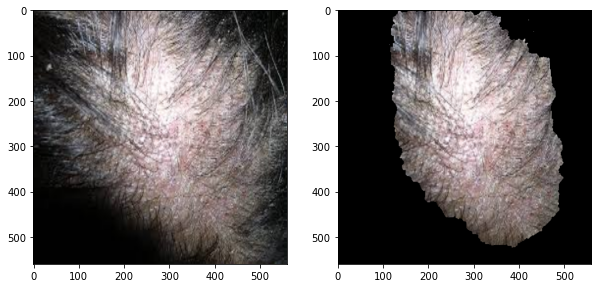

True

In [74]:
#segmentation
img=data[46]
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (1,1,545,545) #rect = (start_x, start_y, width, height)

cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
fimg = img*mask2[:,:,np.newaxis]


fig=plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(121)
ax1.imshow(img)

ax2 = fig.add_subplot(122)
ax2.imshow(fimg)

#plt.colorbar()
plt.show()

fimg=cv2.cvtColor(fimg,cv2.COLOR_BGR2RGB)
cv2.imwrite('/Users/varsha/Desktop/Capstone project/segmented_1/s46.jpg', fimg) 

In [ ]:
#convert to gray-but not happening, so cool
img_dir = "/Users/varsha/Desktop/Capstone project/segmented_1" # Enter Directory of all images  
data_path = os.path.join(img_dir,'*g') 
files = glob.glob(data_path) 
data = [] 

for i in range(0,48):
    for f1 in files:
        tmp=f1.split("/")
        a=tmp[-1].split("s")
        b=a[1].split(".")
        n=b[0]
        if(i==int(n)):
            img = cv2.imread(f1) 
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            data.append(img)
            break
        
df['segmented_img']=data
print(df.head())

img=df['segmented_img'][0]
plt.imshow(img)
plt.imshow(img,cmap="gray")


#ilter
kernel = np.array([[ 1, 1, 1,1,1],
                        [ 1, 1, 1,1,1],
                        [ 1, 1, 1,1,1],
                        [1, 1, 1,1,1], 
                        [1, 1, 1,1,1]
                       ])

print(df.head())
#Area
area=[]
for img in df['segmented_img']:
    cnt=0
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.filter2D(img, -1, kernel)
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[0]):
            if(img[i][j]!=0):
                cnt+=1

    area.append(cnt)

df['area']=area
print(df.head())



#width & height & ratio
central_width=[]
central_height=[]
height_width_ratio=[]
mid_x=280
mid_y=280
for img in df['segmented_img']:
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #img=cv2.filter2D(img, -1, kernel)
    left=0
    right=0
    top=0
    bot=0
    for i in range(mid_x,0,-1):
        if(img[mid_x][i]!=0):
            left+=1
            
    for j in range(mid_x,560):
        if(img[mid_x][j]!=0):
            right+=1
    
    for k in range(mid_y,0,-1):
        if(img[k][mid_y]!=0):
            top+=1
            
    for l in range(mid_y,560):
        if(img[l][mid_y]!=0):
            bot+=1
    
    h=top+bot           
    w=left+right
    h_w=h/w
    height_width_ratio.append(h_w)
    central_width.append(w)
    central_height.append(h)
    
df['height_width_ratio']=height_width_ratio
df['central_width']=central_width
df['central_height']=central_height
print(df.head())

#Smaller-Half-distance, Circle Area, Square Area
smaller_half_dist=[]
circle_area=[]
circle_area_ratio=[]
square_area=[]
square_area_ratio=[]
small=0
circ_a=0

for a in df.index: 
    small=min(df['central_width'][a],df['central_height'][a])
    shd=small/2
    circ_a=math.pi*(shd**2)
    circ_a_rat=circ_a/df['area'][a]
    square_a=4*(shd**2)
    square_a_rat=square_a/df['area'][a]
    square_area.append(square_a)
    square_area_ratio.append(square_a_rat)
    smaller_half_dist.append(shd)
    circle_area.append(circ_a)
    circle_area_ratio.append(circ_a_rat)
    

df['smaller_half_dist']=smaller_half_dist
df['circle_area']=circle_area
df['circle_area_ratio']=circle_area_ratio
print(df.head())

   ID  Tinea captisis  Alopecia areata  Melanoma  Healthy scalp     Img  \
0   1               1                0         0              0  1.jpeg   
1   2               1                0         0              0  2.jpeg   
2   3               1                0         0              0  3.jpeg   
3   4               1                0         0              0  4.jpeg   
4   5               1                0         0              0  5.jpeg   

                                                 pic  \
0  [[[60, 67, 75], [60, 66, 75], [58, 65, 73], [5...   
1  [[[92, 81, 77], [84, 73, 69], [66, 55, 51], [5...   
2  [[[6, 58, 98], [6, 58, 98], [17, 69, 108], [28...   
3  [[[4, 0, 0], [5, 1, 0], [7, 3, 0], [9, 5, 0], ...   
4  [[[12, 4, 1], [12, 4, 1], [13, 5, 2], [13, 5, ...   

                                       segmented_img  
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1  [[[0, 0, 2], [0, 0, 2], [0, 0, 2], [0, 0, 2], ...  
2  [[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]

In [1]:
#hough tranform to count the number of lines-check if you should with segmented/ normal okay?
import cv2

lines = []
image = cv2.imread('/Users/varsha/Desktop/Capstone project/images_1/47.jpeg')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)[1]

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

lines = 0
for c in cnts:
    cv2.drawContours(image, [c], -1, (36,255,12), 3)
    lines += 1
    

df['lines']=lines
print(lines)
cv2.imshow('thresh', thresh)
cv2.imshow('image', image)
cv2.waitKey()

ModuleNotFoundError: No module named 'cv2.cv2'

In [207]:
#skeletonization- just image- see if you should count lines with this
import cv2
import numpy as np


img = cv2.imread('/Users/varsha/Desktop/Capstone project/images_4/170.jpeg',0)
size = np.size(img)
skel = np.zeros(img.shape,np.uint8)

ret,img = cv2.threshold(img,127,255,0)
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
done = False

while( not done):
    eroded = cv2.erode(img,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
    #thinned = cv2.ximgproc.thinning(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))

    zeros = size - cv2.countNonZero(img)
    if zeros==size:
        done = True


print(zeros)
print(skel)
#cv2.imshow("skel",skel)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

19500
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
df.to_csv (r'/Users/varsha/Desktop/Capstone project/1.csv', index = False, header=True)

In [4]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [9]:
#Contours (Texture/Patches)

#convert to gray-but not happening, so cool
img_dir = "/Users/varsha/Desktop/Capstone project/segmented_1" # Enter Directory of all images  
data_path = os.path.join(img_dir,'*g') 
files = glob.glob(data_path) 
data = [] 
num_cont=[]
area_cont=[]
per_cont=[]

for i in range(0,48):
    for f1 in files:
        tmp=f1.split("/")
        a=tmp[-1].split("s")
        b=a[1].split(".")
        n=b[0]
        if(i==int(n)):
            img = cv2.imread(f1,1)
            gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            blur = cv2.GaussianBlur(gray, (3,3),0)
            thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 205, 1)
            contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            filtered = []
            tot_are=0
            tot_per=0
            for c in contours:
                if cv2.contourArea(c) < 1000:
                    continue
                filtered.append(c)
                
            for c in filtered:
                area = cv2.contourArea(c)
                p = cv2.arcLength(c,True)
                tot_are+=area
                tot_per+=p
                
            
            num_cont.append(len(filtered))
            area_cont.append(tot_are)
            per_cont.append(tot_per)
            
            
df['num_contours']=num_cont
df['area_contours']=area_cont
df['len_contours']=per_cont
print(df.head())

   ID  Tinea captisis  Alopecia areata  Melanoma  Healthy scalp     Img  \
0   1               1                0         0              0  1.jpeg   
1   2               1                0         0              0  2.jpeg   
2   3               1                0         0              0  3.jpeg   
3   4               1                0         0              0  4.jpeg   
4   5               1                0         0              0  5.jpeg   

                                                 pic  num_contours  \
0  [[[60, 67, 75], [60, 66, 75], [58, 65, 73], [5...             3   
1  [[[92, 81, 77], [84, 73, 69], [66, 55, 51], [5...             6   
2  [[[6, 58, 98], [6, 58, 98], [17, 69, 108], [28...            10   
3  [[[4, 0, 0], [5, 1, 0], [7, 3, 0], [9, 5, 0], ...            10   
4  [[[12, 4, 1], [12, 4, 1], [13, 5, 2], [13, 5, ...             6   

   area_contours  len_contours  
0       104954.5   5440.028013  
1       376831.5   9532.359303  
2       342755.5  17617.35908

In [3]:
from PIL import Image

img = Image.open('/Users/varsha/Desktop/Capstone project/images_3/117.jpeg')
imgGray = img.convert('L')
imgGray.save('/Users/varsha/Desktop/2.jpeg')